In [79]:
import pandas as pd
import os
import glob
from astropy.utils.data import get_pkg_data_filename
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt
import numpy as np
import warnings
import scipy as scipy
from scipy import optimize
from scipy.optimize import differential_evolution
from tqdm import tqdm
from matplotlib.pyplot import cm

In [80]:
hdulist = fits.open('../data/composite_Io_eclipsed.fits')
evt_data = Table(hdulist[1].data)
image_data = hdulist[1].data
df = pd.read_csv('../data/Io_Master_Line_List (1).csv') #spaces in csv file will make df object type and not float64
df_wavelength = df['Wavelength']
df_species = df['Species']

In [81]:
def gaussian(x, mu, sig, A):
    return A*np.exp(-(x-mu)**2/(2*sig**2))

In [82]:
def double_gaussian(x, mu, sig, A, mu2, sig2, A2):
    return gaussian(x, mu, sig, A)+gaussian(x, mu2, sig2, A2)

In [83]:
array = pd.read_csv('../data/test_array.csv') #spaces in csv file will make df object type and not float64

In [84]:
guess = array.to_numpy()
wl = evt_data['WAVELENGTH'].T
flux = evt_data['FLUX'].T
wl = wl.data
flux = flux.data
wl = wl.flatten()
flux = flux.flatten()

Let's use the method of least_squares() with bounds instead of least_sq().

In [85]:
import scipy.optimize as sop
import numpy as np
def ftest(x):
    x,y,z = x
    data = np.array([3.65,2.41,1.59])# arbitrary & just for testing
    model = np.array([x**2,y**2,z**2])# arbitrary & just for testing
    residuals = data - model 
    return residuals
def ftest2(x):
    return sum(ftest(x)**2)# to ask fmin to minimize the chi2 but it can be anything
p0 = np.array([1,2,3])# arbitrary & just for testing
opt = sop.fmin(ftest2, p0)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 73
         Function evaluations: 131


In [86]:
C = np.delete(guess, 1, 1)

In [87]:
test = C.astype('float64')
test = np.delete(guess, 1, 1)
test = test.astype(dtype=np.float64)

In [115]:
errfunc1 = lambda p, x, y: (gaussian(x, *p) - y)**2
errfunc2 = lambda p, x, y: (double_gaussian(x, *p) - y)**2

In [538]:
x = 30
guess1 = test[x]
guess2 = np.hstack((guess1, test[x+1]))
#guess1 = [1389.693, 0.2, 0.02] #manually input guess where sigma is smaller

opt = optimize.least_squares(errfunc1, guess1, args=(wl, flux/10**-13), bounds=([guess1[0]-0.5, 0, 0],
                                                                        [guess1[0]+0.5, np.inf, np.inf]))
nob = optimize.least_squares(errfunc1, guess1, args=(wl, flux/10**-13))
opt2 = optimize.least_squares(errfunc2, guess2, args=(wl, flux/10**-13), bounds=([guess2[0]-0.5, 0, 0,
                                                                         guess2[3]-0.5, 0, 0], [guess2[0]+0.5,
                                                                         np.inf, np.inf, guess2[3]+0.5, np.inf, np.inf]))
guess1

array([1401.514, 0.23, 1.6e-07], dtype=object)

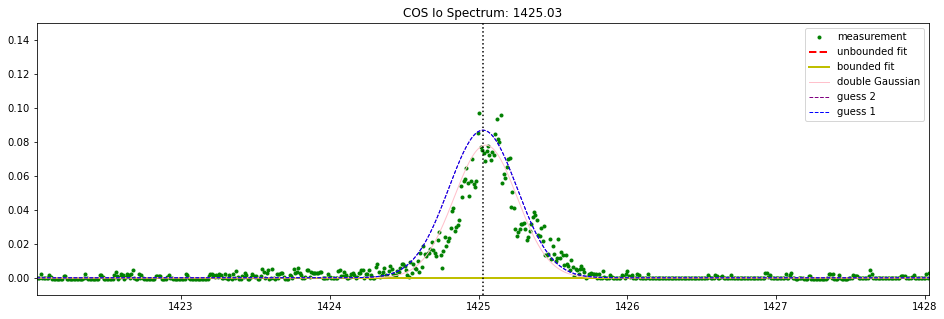

In [537]:
plt.figure(figsize=(16, 5))
plt.plot(wl, flux/10**-13,'g.', label='measurement')
plt.plot(wl, gaussian(wl, *nob['x']),
    lw=2, c='red', ls='--', label='unbounded fit')
plt.plot(wl, gaussian(wl, *opt['x']),
    lw=2, c='y', label='bounded fit')
plt.plot(wl, double_gaussian(wl, *opt2['x']),
    lw=1, c='pink', label='double Gaussian')
plt.plot(wl, double_gaussian(wl, *guess2),
    lw=1, c='purple', ls='--', label='guess 2')
plt.plot(wl, gaussian(wl, *guess1),
    lw=1, c='b', ls='--', label='guess 1')
plt.axvline(guess1[0], color = 'black', linestyle = 'dotted')
plt.title('COS Io Spectrum: {}'.format(guess1[0]))
plt.ylim(-0.01,0.15)
plt.xlim(guess1[0]-3,guess1[0]+3)
plt.legend(loc='best')

Using x=86 when the wavelength is 1425.03, we can find the amplitude, mu, and sigma.

In [321]:
ans = opt['x']
mu = ans[0]
sig = ans[1]
amp = ans[2]

In [322]:
mu,sig,amp

(1425.0445939651336, 0.22405151478212873, 0.08615257812705991)

In [37]:
brightness = ((2*np.pi)**.5)*(amp*sig)
brightness

0.045517316220213516

In [38]:
new_amp = amp*1e-13
new_b = ((2*np.pi)**.5)*(new_amp*sig)

In [39]:
new_b

4.551731622021352e-15

Now that we have the brightest lines, let's plot all of them.

In [539]:
array = pd.read_csv('../data/bright_lines.csv') #spaces in csv file will make df object type and not float64
guess = array.to_numpy()

In [542]:
C = np.delete(guess, 1, 1)
C = np.delete(C, 2, 1)
C = np.delete(C, 3, 1)
C = np.delete(C, 3, 1)
C = np.delete(C, 3, 1)
C = np.delete(C, 3, 1)
test = np.delete(C, 3, 1)

In [543]:
errfunc1 = lambda p, x, y: (gaussian(x, *p) - y)**2

In [544]:
def fit_whole_spectra(array):
    params = np.zeros((len(test),3))
    for index in tqdm(range(0, len(array))):
        guess1 = test[index]
        optim = optimize.least_squares(errfunc1, guess1, args=(wl, flux/10**-13),
                                       bounds=([guess1[0]-0.5, 0, 0],[guess1[0]+0.5, np.inf, np.inf]))
        params[index] = optim['x']
        plt.figure(figsize=(16, 5))
        plt.title('COS Io Spectrum: {}'.format(guess1[0]))
        plt.plot(wl, flux/10**-13,'g.', label='measurement')
        plt.plot(wl, gaussian(wl, *params[index]),
            lw=2, c='red', ls='--', label='bounded fit fit')
        plt.ylim(-0.01,0.15)
        plt.xlim(guess1[0]-3,guess1[0]+3)
        plt.legend(loc='best')
    return params

 61%|█████████████████████████████████████████████████▋                                | 20/33 [00:01<00:00, 16.61it/s]C:\Users\jojoa\.conda\envs\io_env\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:02<00:00, 16.33it/s]


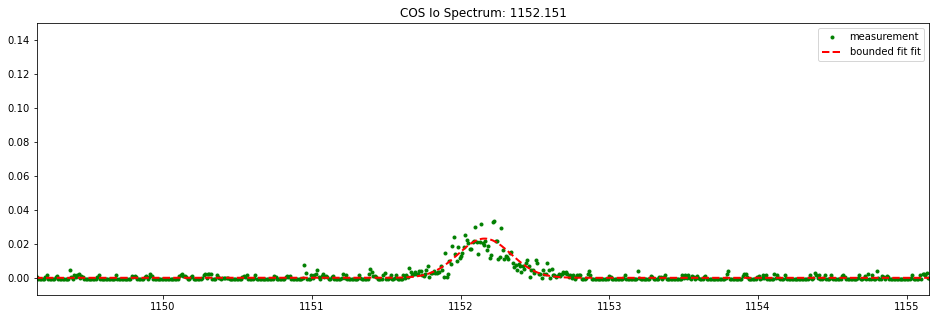

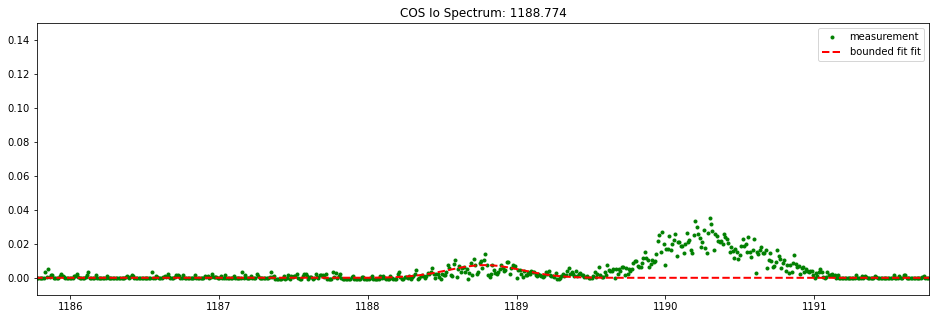

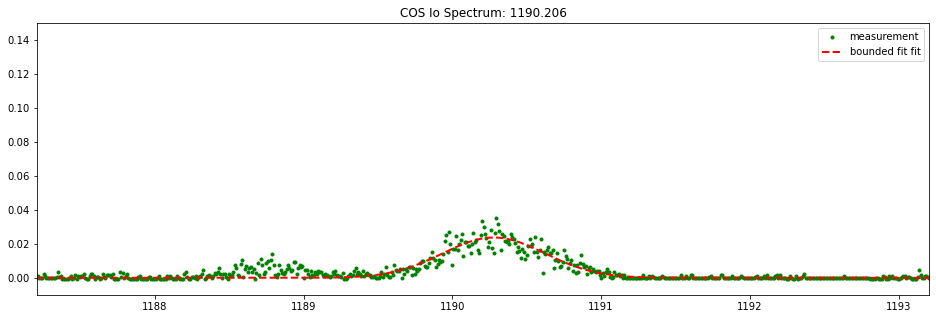

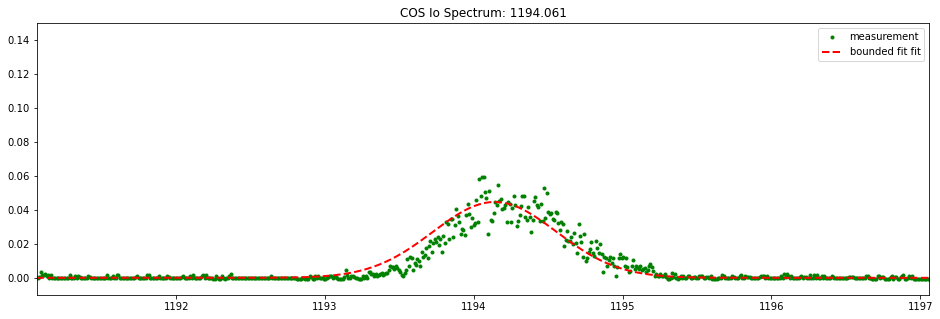

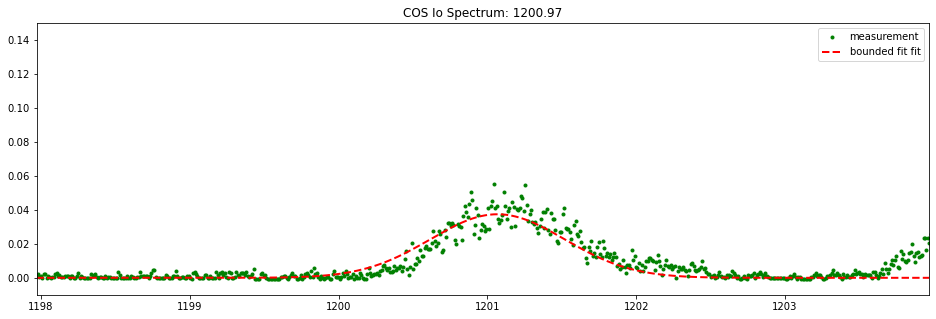

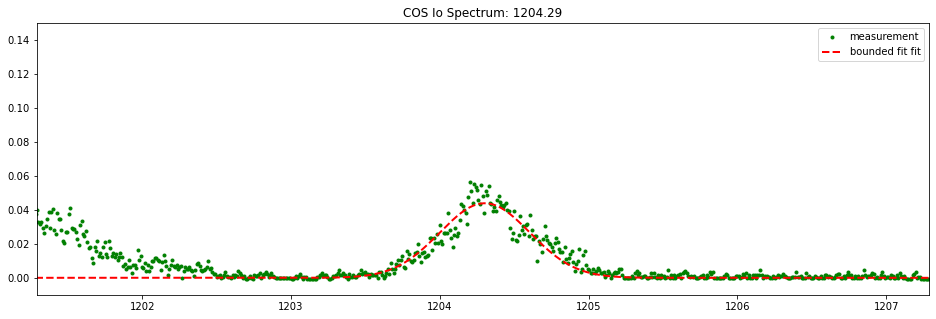

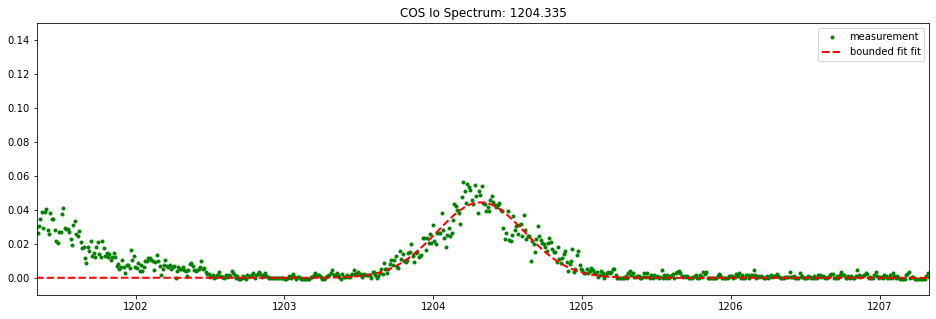

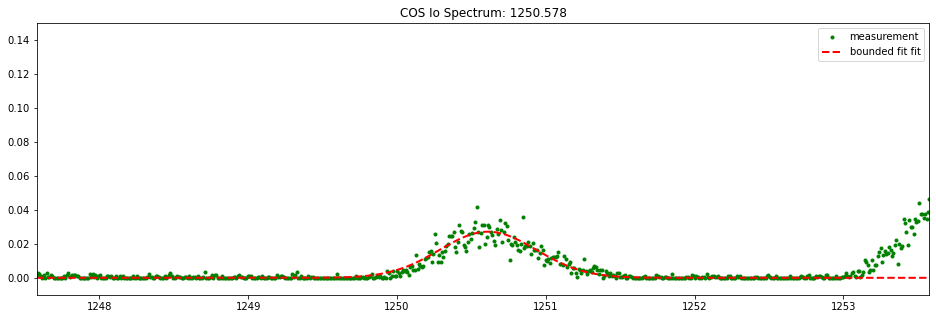

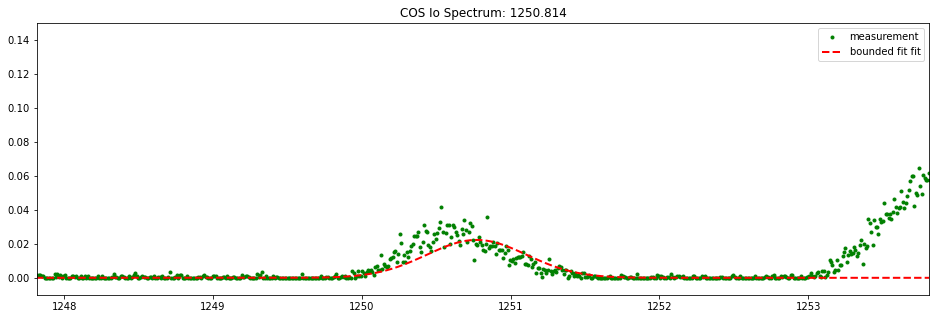

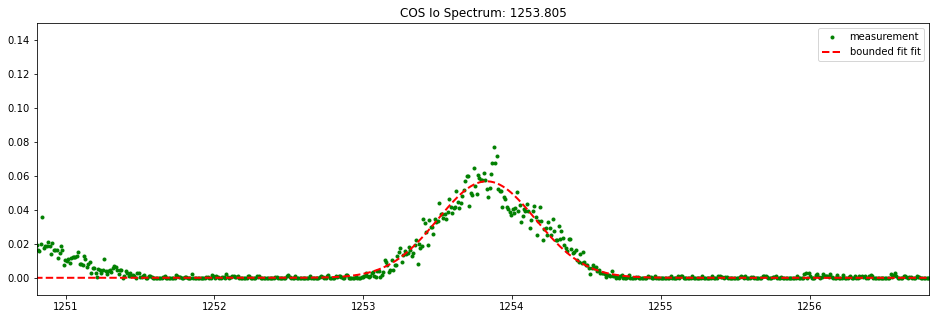

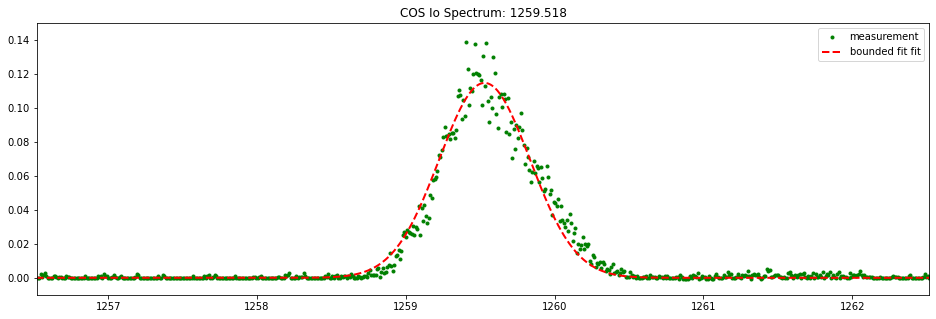

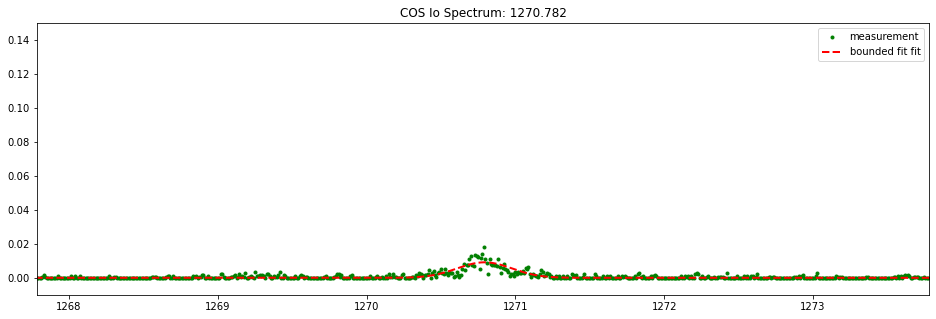

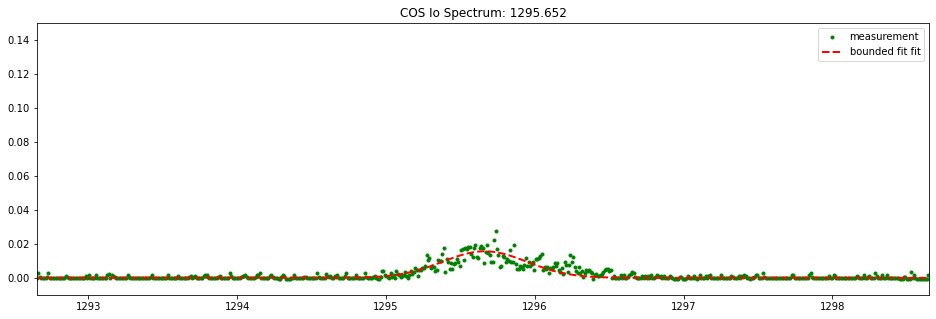

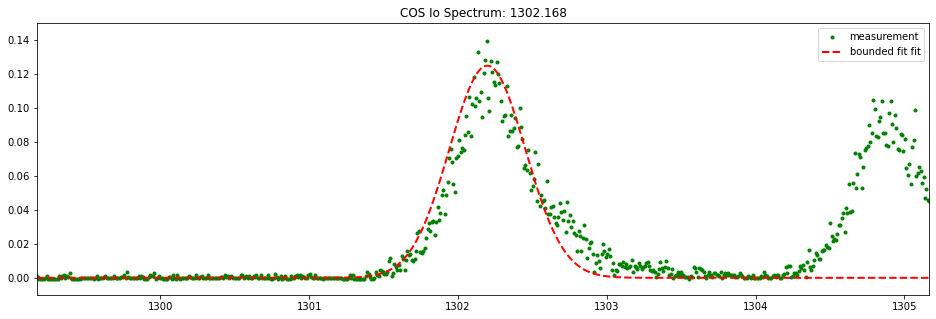

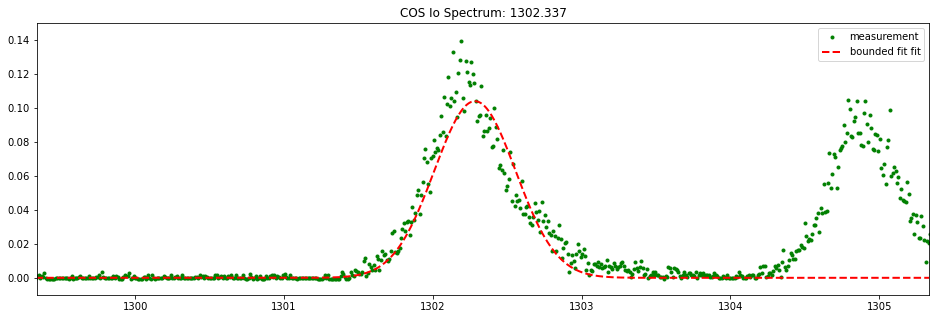

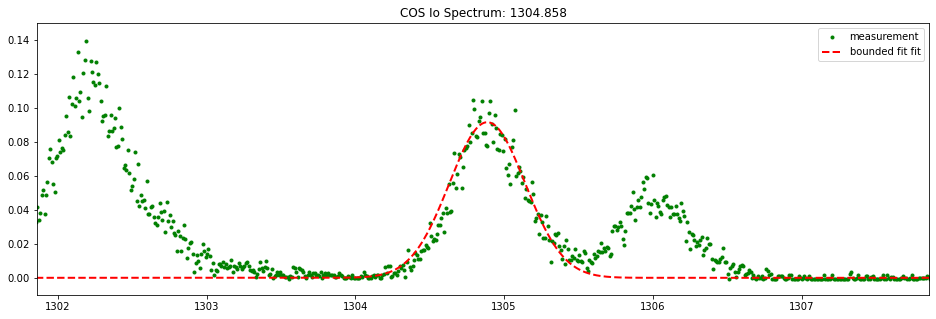

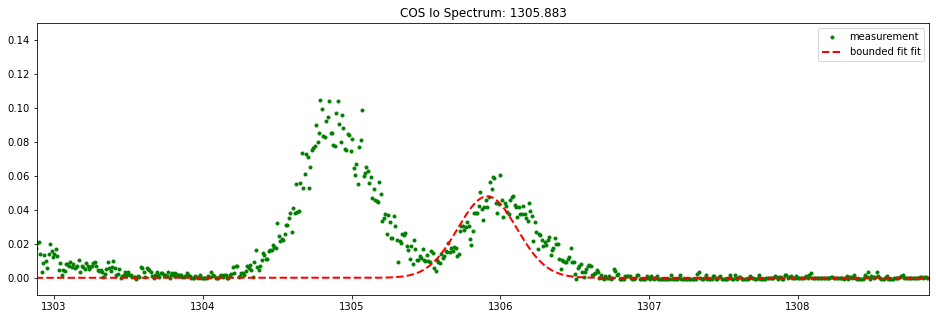

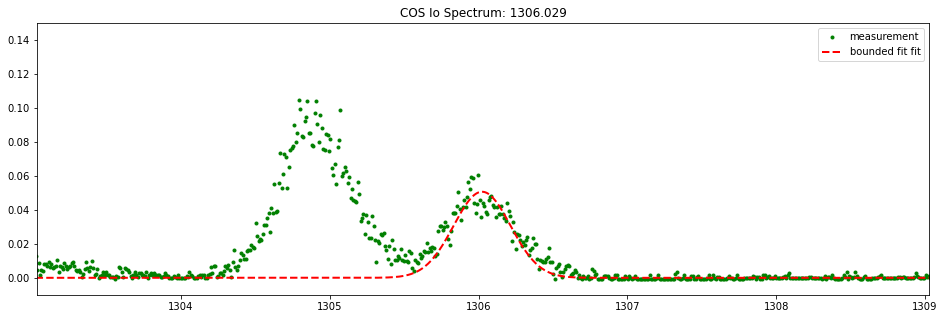

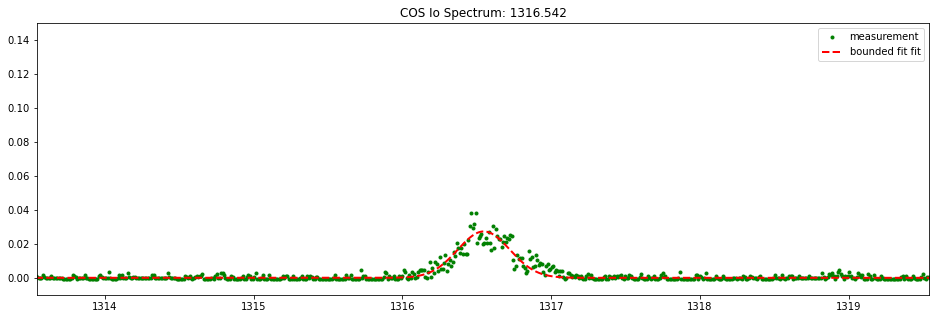

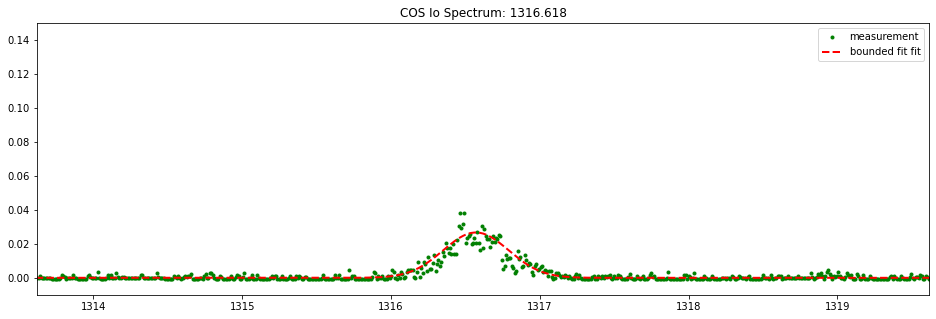

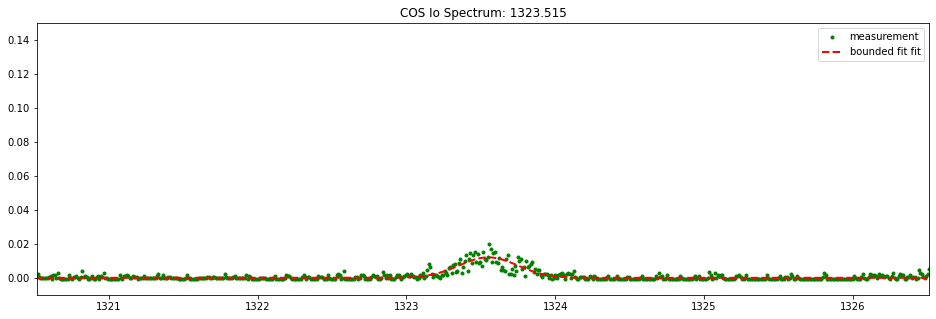

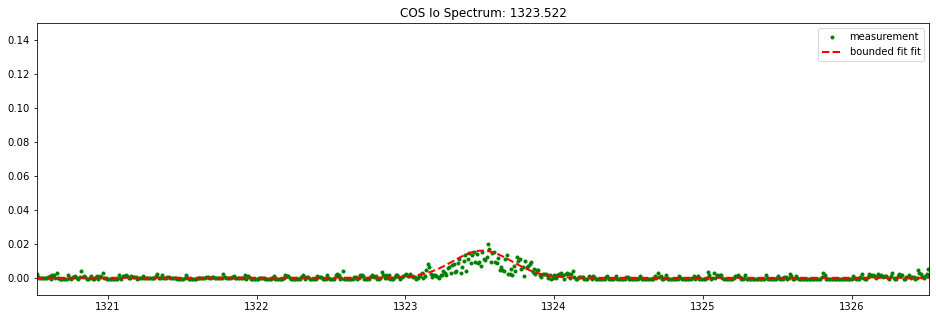

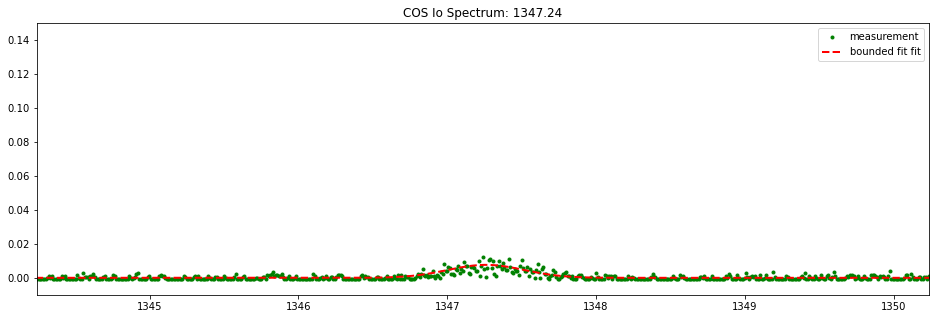

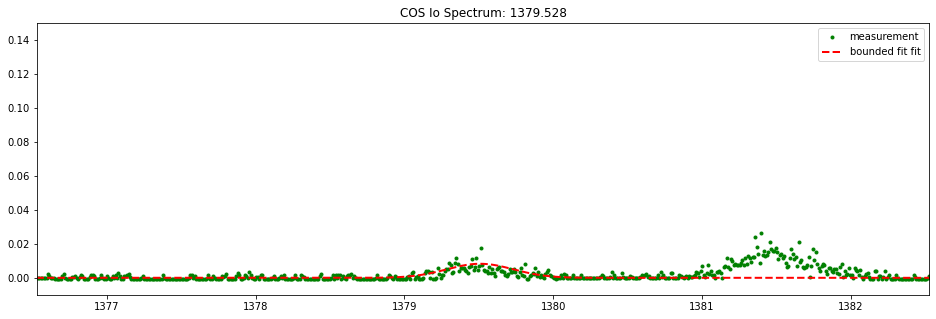

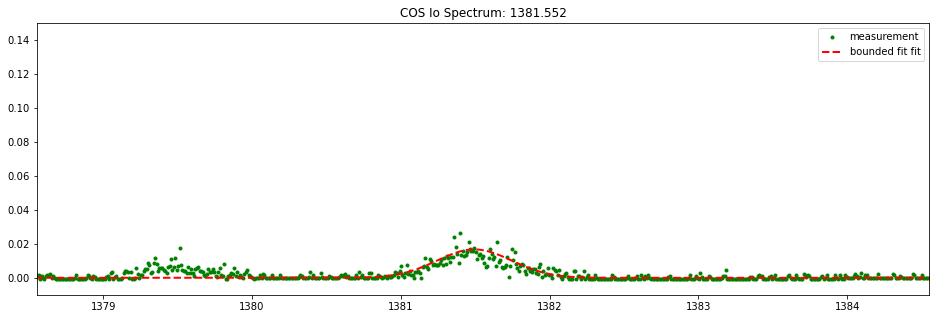

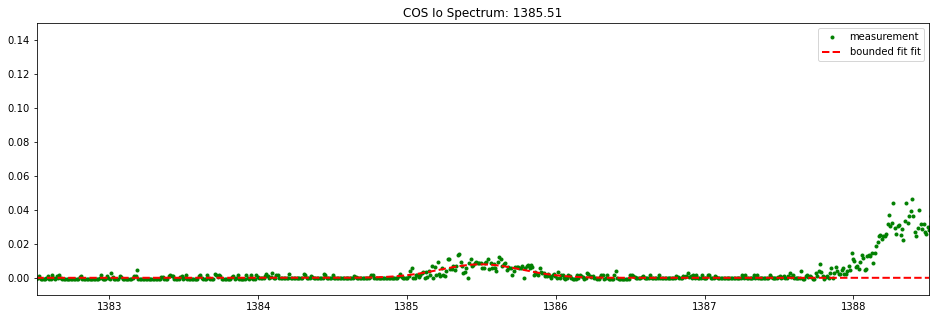

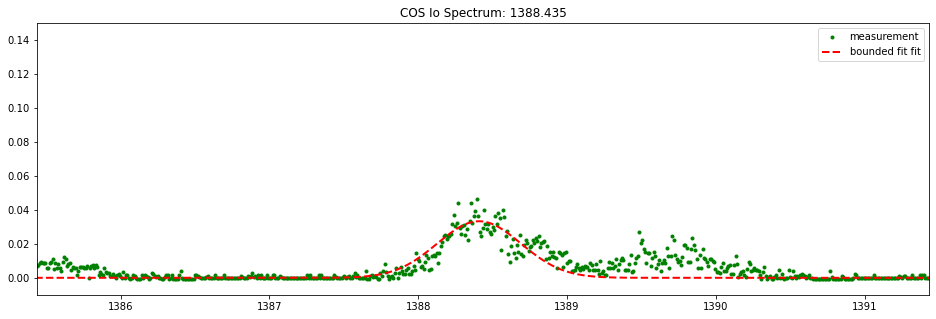

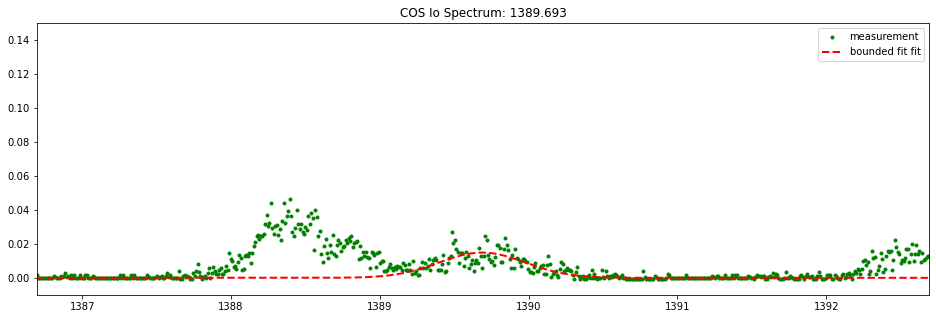

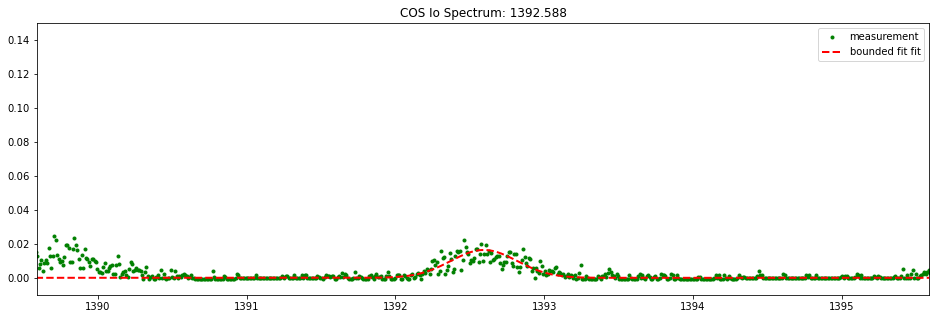

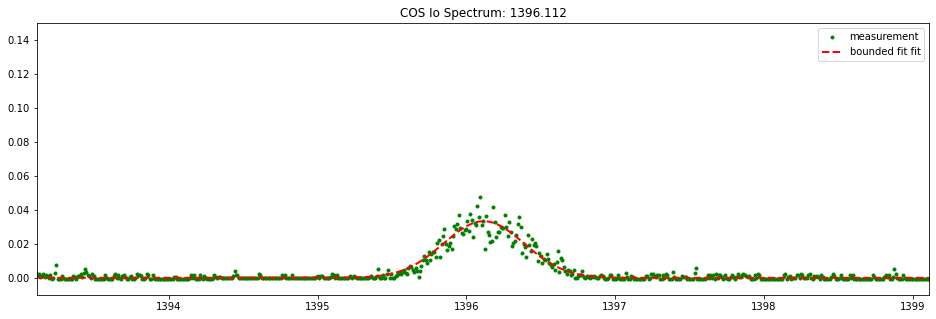

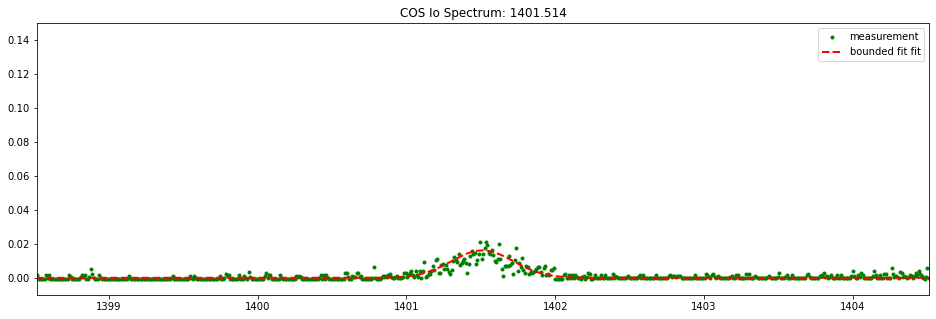

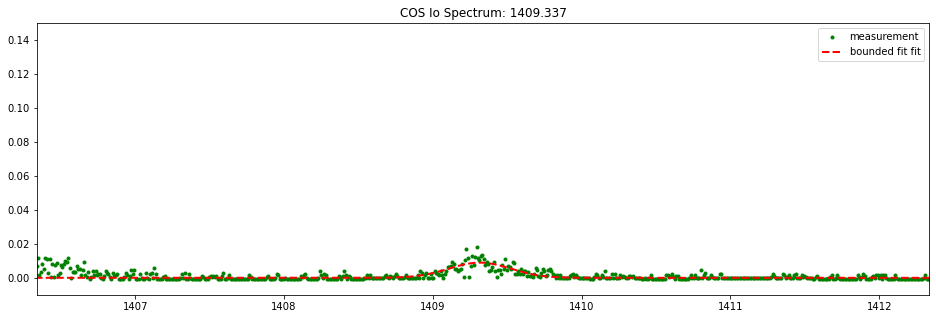

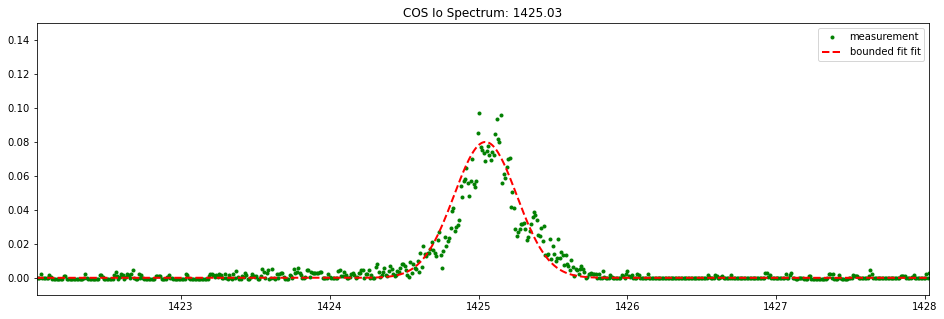

In [545]:
params = fit_whole_spectra(test)

In [546]:
mu = params[:,0]
sigma = params[:,1]
amp = params[:,2]

In [549]:
os = array['Oscillator Strength']

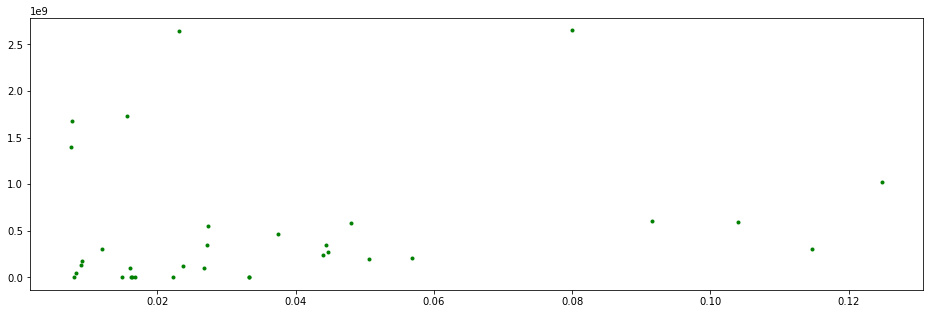

In [552]:
plt.figure(figsize=(16, 5))
#plt.title('COS Io Spectrum: {}'.format(guess1[0]))
plt.plot(amp, os,'g.', label='measurement')